# GAMA-15 master catalogue
## Preparation of DECam Legacy Survey data

This catalogue comes from `dmu0_DECaLS`.

In the catalogue, we keep:

- The `object_id` as unique object identifier;
- The position;
- The g, r, i, z, Y aperture magnitude (2”);
- The g, r, i, z, Y kron fluxes and magnitudes.


In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
04829ed (Thu Nov 2 16:57:19 2017 +0000)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, flux_to_mag

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "decals_ra"
DEC_COL = "decals_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        "objid": "decals_id",
        "ra": "decals_ra",
        "dec": "decals_dec",
        "decam_flux": "decam_flux_TEMP",
        "decam_flux_ivar": "decam_flux_ivar_TEMP",
        "decam_apflux": "decam_apflux_TEMP",
        "decam_apflux_ivar": "decam_apflux_ivar_TEMP",
       
    })


catalogue = Table.read("../../dmu0/dmu0_DECaLS/data/DECaLS_GAMA-15.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2017

catalogue.add_column(Column(catalogue["decam_flux_TEMP"][:,0], name="f_decam_g"))
catalogue.add_column(Column(catalogue["decam_flux_TEMP"][:,1], name="f_decam_r"))
catalogue.add_column(Column(catalogue["decam_flux_TEMP"][:,2], name="f_decam_i"))
catalogue.add_column(Column(catalogue["decam_flux_TEMP"][:,3], name="f_decam_z"))
catalogue.add_column(Column(catalogue["decam_flux_TEMP"][:,4], name="f_decam_y"))

catalogue.add_column(Column(catalogue["decam_flux_ivar_TEMP"][:,0], name="ferr_decam_g"))
catalogue.add_column(Column(catalogue["decam_flux_ivar_TEMP"][:,1], name="ferr_decam_r"))
catalogue.add_column(Column(catalogue["decam_flux_ivar_TEMP"][:,2], name="ferr_decam_i"))
catalogue.add_column(Column(catalogue["decam_flux_ivar_TEMP"][:,3], name="ferr_decam_z"))
catalogue.add_column(Column(catalogue["decam_flux_ivar_TEMP"][:,4], name="ferr_decam_y"))

#For the aperture fluxes, there are 8 (0-7), we take 4 (2.0")
#DECam aperture fluxes on the co-added images in apertures of radius [0.5,0.75,1.0,1.5,2.0,3.5,5.0,7.0] arcsec in ugrizY
catalogue.add_column(Column(catalogue["decam_apflux_TEMP"][:,0], name="f_ap_decam_g")[:,4])
catalogue.add_column(Column(catalogue["decam_apflux_TEMP"][:,1], name="f_ap_decam_r")[:,4])
catalogue.add_column(Column(catalogue["decam_apflux_TEMP"][:,2], name="f_ap_decam_i")[:,4])
catalogue.add_column(Column(catalogue["decam_apflux_TEMP"][:,3], name="f_ap_decam_z")[:,4])
catalogue.add_column(Column(catalogue["decam_apflux_TEMP"][:,4], name="f_ap_decam_y")[:,4])

catalogue.add_column(Column(catalogue["decam_apflux_ivar_TEMP"][:,0], name="ferr_ap_decam_g")[:,4])
catalogue.add_column(Column(catalogue["decam_apflux_ivar_TEMP"][:,1], name="ferr_ap_decam_r")[:,4])
catalogue.add_column(Column(catalogue["decam_apflux_ivar_TEMP"][:,2], name="ferr_ap_decam_i")[:,4])
catalogue.add_column(Column(catalogue["decam_apflux_ivar_TEMP"][:,3], name="ferr_ap_decam_z")[:,4])
catalogue.add_column(Column(catalogue["decam_apflux_ivar_TEMP"][:,4], name="ferr_ap_decam_y")[:,4])

catalogue.remove_columns(["decam_flux_TEMP", 
                          "decam_flux_ivar_TEMP", 
                          "decam_apflux_TEMP", 
                          "decam_apflux_ivar_TEMP"])

# Clean table metadata
catalogue.meta = None

In [5]:


# Adding flux and band-flag columns
for col in catalogue.colnames:
    catalogue[col].unit = None
    if col.startswith('f_'):
        
        #Replace 0 flux with NaN and 
        catalogue[col][catalogue[col] == 0.0] = np.nan
        
        #Replace 1/sigma^2 with sigma 
        errcol = "ferr{}".format(col[1:])
        catalogue[errcol][catalogue[errcol] == 0.0] = np.nan
        catalogue[errcol] = np.sqrt(1/np.array(catalogue[errcol]))
        #catalogue[errcol][catalogue[errcol] == None] = np.nan
        
        #Replace nanomaggies with uJy
        #a nanomaggy is approximately 3.631×10-6 Jy - http://www.sdss3.org/dr8/algorithms/magnitudes.php#nmgy
        catalogue[col] = catalogue[col]  * 3.631        
        catalogue[errcol] = catalogue[errcol]  * 3.631
        
        #Compute magnitudes and errors in magnitudes. This function expects Jy so must multiply uJy by 1.e-6
        mag, error = flux_to_mag(np.array(catalogue[col])* 1.e-6, np.array(catalogue[errcol])* 1.e-6)
        
        
        catalogue.add_column(Column(mag, name="m{}".format(col[1:])))
        catalogue.add_column(Column(error, name="m{}".format(errcol[1:])))
        
        # Band-flag column
        if 'ap' not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
#remove units from table
for col in catalogue.colnames:
    catalogue[col].unit = None

/opt/herschelhelp_internal/herschelhelp_internal/utils.py:76: RuntimeWarning: invalid value encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6


In [6]:
catalogue[:10].show_in_notebook()

idx,decals_id,decals_ra,decals_dec,f_decam_g,f_decam_r,f_decam_i,f_decam_z,f_decam_y,ferr_decam_g,ferr_decam_r,ferr_decam_i,ferr_decam_z,ferr_decam_y,f_ap_decam_g,f_ap_decam_r,f_ap_decam_i,f_ap_decam_z,f_ap_decam_y,ferr_ap_decam_g,ferr_ap_decam_r,ferr_ap_decam_i,ferr_ap_decam_z,ferr_ap_decam_y,m_decam_g,merr_decam_g,flag_decam_g,m_decam_r,merr_decam_r,flag_decam_r,m_decam_i,merr_decam_i,flag_decam_i,m_decam_z,merr_decam_z,flag_decam_z,m_decam_y,merr_decam_y,flag_decam_y,m_ap_decam_g,merr_ap_decam_g,m_ap_decam_r,merr_ap_decam_r,m_ap_decam_i,merr_ap_decam_i,m_ap_decam_z,merr_ap_decam_z,m_ap_decam_y,merr_ap_decam_y
0,51,210.235214181,1.12500463358,nan,nan,nan,nan,449.749,nan,nan,nan,nan,0.475968,nan,nan,nan,nan,432.452,nan,nan,nan,nan,0.553593,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,17.2676,0.00114903,False,nan,nan,nan,nan,nan,nan,nan,nan,17.3102,0.00138988
1,89,210.225615663,1.12526891184,nan,nan,nan,nan,2.77798,nan,nan,nan,nan,0.45862,nan,nan,nan,nan,2.52825,nan,nan,nan,nan,0.64299,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,22.7907,0.179245,False,nan,nan,nan,nan,nan,nan,nan,nan,22.893,0.276126
2,94,210.209940006,1.12651116397,nan,nan,nan,nan,5.31627,nan,nan,nan,nan,0.298581,nan,nan,nan,nan,6.54192,nan,nan,nan,nan,0.556549,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,22.086,0.0609788,False,nan,nan,nan,nan,nan,nan,nan,nan,21.8607,0.0923682
3,95,210.2100703,1.12544403962,nan,nan,nan,nan,2.74341,nan,nan,nan,nan,0.395157,nan,nan,nan,nan,2.74479,nan,nan,nan,nan,0.556549,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,22.8043,0.156388,False,nan,nan,nan,nan,nan,nan,nan,nan,22.8037,0.22015
4,104,210.224415585,1.12666181126,nan,nan,nan,nan,2.15987,nan,nan,nan,nan,0.343944,nan,nan,nan,nan,1.63154,nan,nan,nan,nan,0.64299,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,23.0639,0.172896,False,nan,nan,nan,nan,nan,nan,nan,nan,23.3685,0.427888
5,107,210.248797623,1.12681249871,nan,nan,nan,nan,1.88688,nan,nan,nan,nan,0.295215,nan,nan,nan,nan,1.85369,nan,nan,nan,nan,0.553593,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,23.2106,0.16987,False,nan,nan,nan,nan,nan,nan,nan,nan,23.2299,0.324249
6,110,210.237120152,1.12711938708,nan,nan,nan,nan,2.73614,nan,nan,nan,nan,0.295524,nan,nan,nan,nan,2.7931,nan,nan,nan,nan,0.553593,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,22.8072,0.117268,False,nan,nan,nan,nan,nan,nan,nan,nan,22.7848,0.215193
7,113,210.180465027,1.12821069862,nan,nan,nan,nan,5.14844,nan,nan,nan,nan,0.351405,nan,nan,nan,nan,5.34439,nan,nan,nan,nan,0.611234,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,22.1208,0.0741067,False,nan,nan,nan,nan,nan,nan,nan,nan,22.0803,0.124175
8,114,210.185754657,1.12822445478,nan,nan,nan,nan,2.69326,nan,nan,nan,nan,0.349669,nan,nan,nan,nan,2.91243,nan,nan,nan,nan,0.619833,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,22.8243,0.140963,False,nan,nan,nan,nan,nan,nan,nan,nan,22.7394,0.23107
9,122,210.191064132,1.12910938439,nan,nan,nan,nan,9.37015,nan,nan,nan,nan,0.477436,nan,nan,nan,nan,9.37737,nan,nan,nan,nan,0.665165,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,21.4706,0.0553214,False,nan,nan,nan,nan,nan,nan,nan,nan,21.4698,0.0770146


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [7]:
SORT_COLS = [] #TODO add order
FLAG_NAME = 'decals_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(
    catalogue, RA_COL, DEC_COL, 
    sort_col= SORT_COLS,
    flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


The initial catalogue had 3897945 sources.
The cleaned catalogue has 3897085 sources (860 removed).
The cleaned catalogue has 860 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [8]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_GAMA-15.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

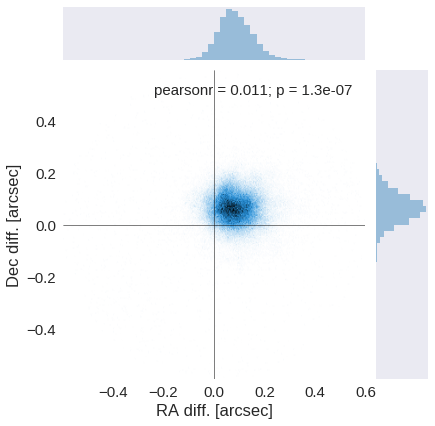

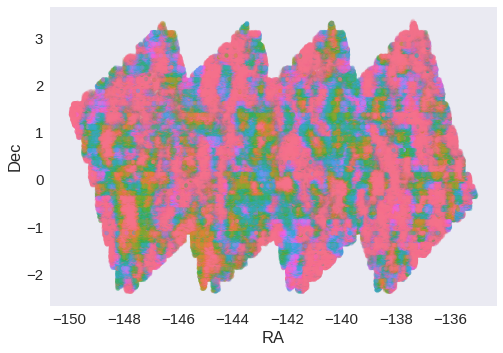

In [9]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

In [10]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords, near_ra0=True
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.08036900230763422 arcsec
Dec correction: -0.06568627127423454 arcsec


In [11]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

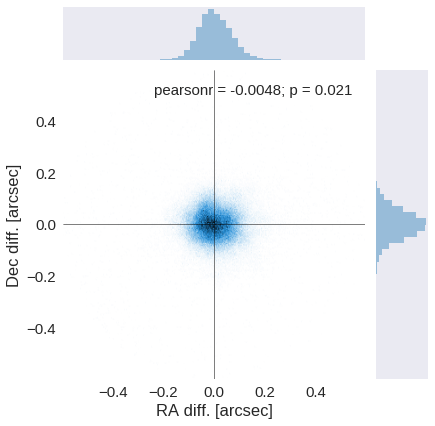

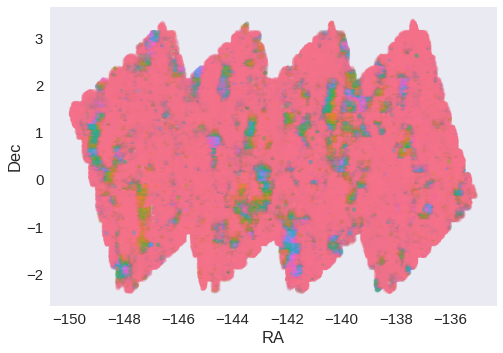

In [12]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

## IV - Flagging Gaia objects

In [13]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [14]:
GAIA_FLAG_NAME = "decals_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

234283 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [15]:
catalogue.write("{}/DECaLS.fits".format(OUT_DIR), overwrite=True)